# A quanvolutional neural network for weld classification

## Prerequisite

If you are not familiar with convolutional or quanvolutional networks and layers, a demonstration is provided in the [quanvolutional.ipynb](Task_3.ipynb) file.

In [1]:
# Import Pennylane libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.src import activations
from keras.src import initializers
from keras.src import ops
from keras.src.layers.layer import Layer
from keras.src.utils.argument_validation import standardize_tuple
_LIGHTNING_GPU = 'lightning.gpu'

# Import Matplotlib
import matplotlib.pyplot as plt

# Auxiliary modules
import json
import os
from PIL import Image

# Accelerate with GPU
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# Space and time management
LABEL_LIMIT = 6144                # Mechanism to save time and space by label count
SCALE_FACTOR = 16                 # Downscale factor
DEVICE = _LIGHTNING_GPU           # Use lightning-gpu for GPU acceleration on quantum as well
MAX_CHANNELS =  25                      # Max number of channels/wires supported
MAX_KERNELSIZE = 5                      # Max size of kernel

2024-08-31 00:47:12.456030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 00:47:12.467544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 00:47:12.470786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 00:47:12.479958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 00:47:13.068980: W ten

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Path

The code for extracting the dataset is manual and based on an existing [Kaggle submission]('https://www.kaggle.com/code/mayankgupta1609/model-1'). Please note this step may take at least ten minutes to conclude and consume large amounts of memory.

In [2]:
# Dataset
SAVE_PATH = "/home/samaria/S/Trainset/al5083/"           # Data saving folder (locally)
PREPROCESS = True                           # If False, skip quantum processing and load data from SAVE_PATH
SETSEED = False
if SETSEED:
    np.random.seed(0)           # Seed for NumPy random number generator
    tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Image size
HEIGHT = 800
WIDTH = 974
LABELS = 6                # Units of dense second layer
LABEL_TITLES = ["good","burn","contamination","lack_fusion", "misalignment", "lack_penetration"]

# Manual extraction Source: https://www.kaggle.com/code/mayankgupta1609/model-1
def load_data(path, subpath, limit=LABEL_LIMIT):
    images, labels, defectives, sources = [], [], [], []
    labelsource = None
    with open(SAVE_PATH + "{0:s}/{0:s}.json".format(subpath), 'r') as json_file:
        labelsource = json.load(json_file) # returns a JSON of source-label pairs
    label_count = [0]*LABELS
    for folder in os.listdir(path + subpath):
        folder_path = os.path.join(path + subpath, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = labelsource[key_name]

                # Mechanism to save time and space
                if(label_count[label] >= limit):
                    continue
                if(len(images) >= LABELS*limit):
                    break
                label_count[label] += 1

                # Extract image, with downscaling as mechanism to save space
                image = Image.open(img_path)
                image = image.resize((HEIGHT//SCALE_FACTOR, WIDTH//SCALE_FACTOR), Image.Resampling.LANCZOS)

                # Convert to numpy, and save label
                images.append(np.array(image))
                labels.append(label)
                defectives.append([int(bool(label))])
                sources.append(key_name)
                
                if(len(images)%1==0):
                    print(f"Total images loaded : {len(images)}, Label count : {label_count}", end = '\r')
            # End of image processing
        # Skip non-folders
    # End of folder processing, return normalized numpy array of images, labels array, and sources list. 
    # Add extra dimension for convolution channels
    return np.array(np.array(images)[..., tf.newaxis], requires_grad=False) / 255, np.array(labels), np.array(defectives), sources

train_images, train_labels, train_defective, train_sources = load_data(SAVE_PATH, "train")
print()
test_images, test_labels, train_defective, test_sources = load_data(SAVE_PATH, "test")
print()
RANDOMINDEX = np.random.randint(len(train_images))
print("Size of initial tensor #{3:d}: {0:s}, status: {1:d}, filename: '{2:s}'".format( \
    str(train_images[RANDOMINDEX].shape), train_labels[RANDOMINDEX], train_sources[RANDOMINDEX], RANDOMINDEX))

Total images loaded : 23871, Label count : [6144, 1783, 6144, 4028, 2953, 2819]
Total images loaded : 6588, Label count : [2189, 351, 2078, 1007, 729, 234]
Size of initial tensor #12276: (60, 50, 1), status: 0, filename: '170905-114307-Al 2mm/frame_00479.png'


## Displaying sample data

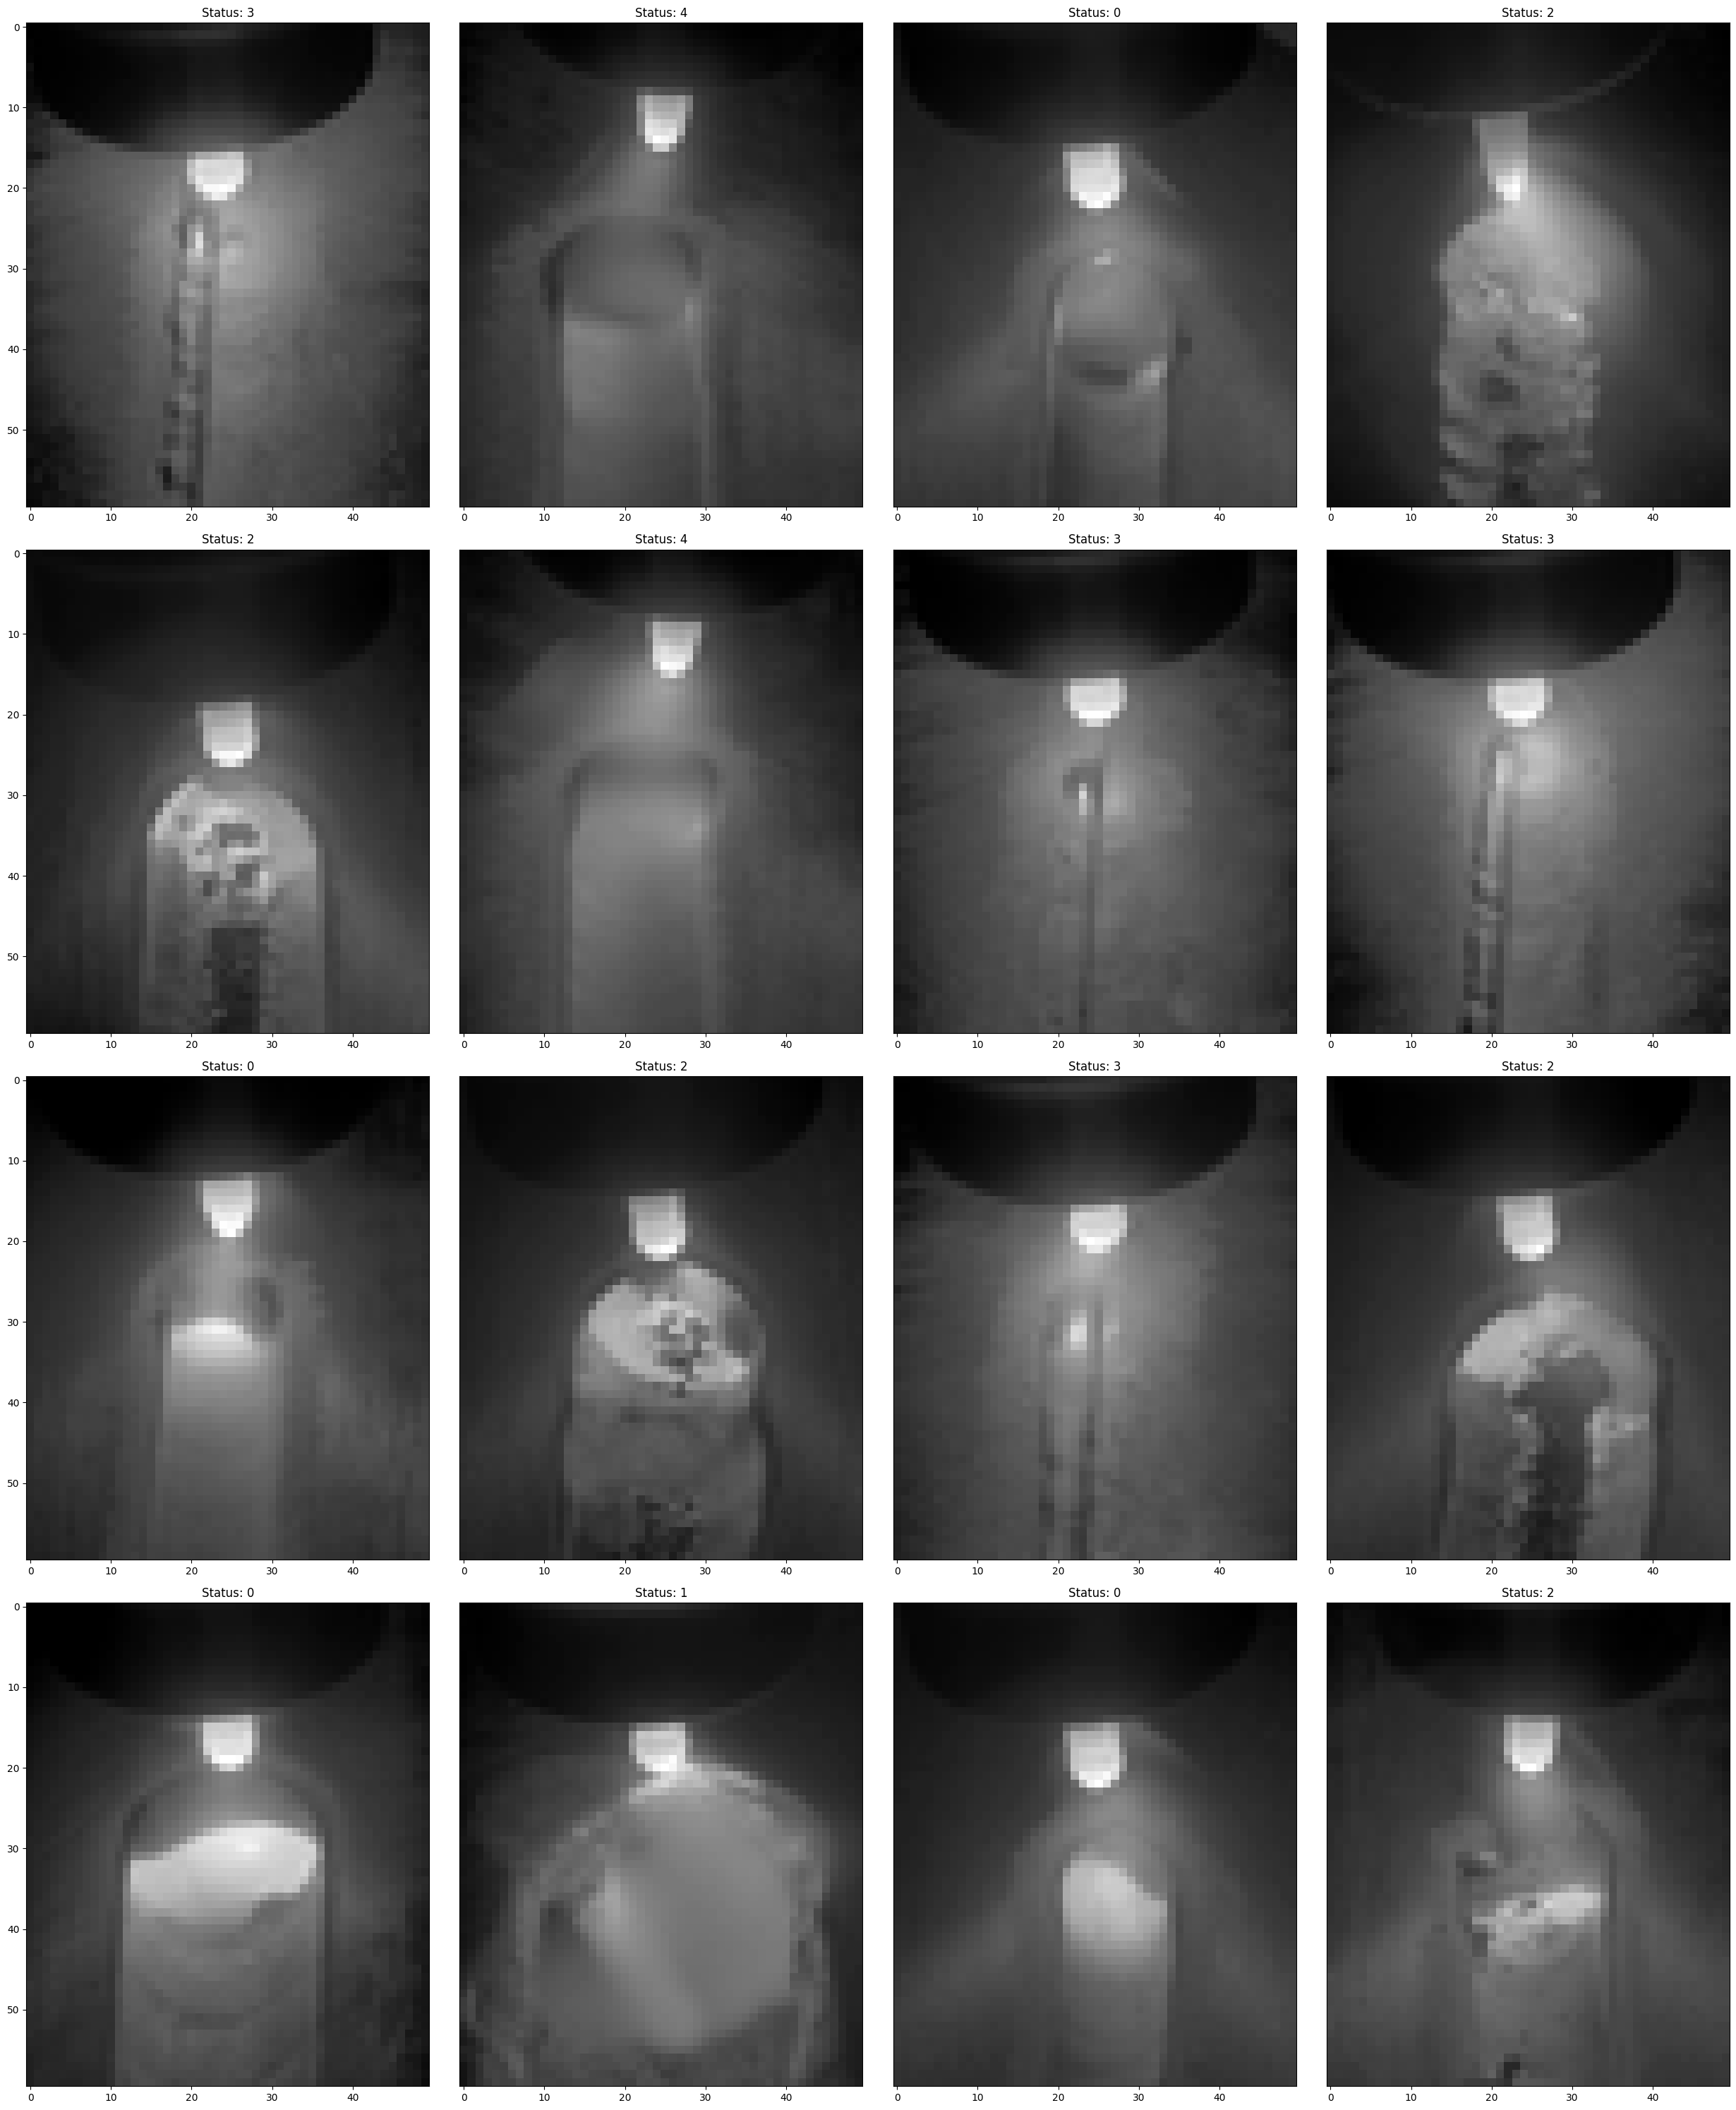

In [3]:
DISPLAYSQRT = 4
fig, axes = plt.subplots(DISPLAYSQRT, DISPLAYSQRT, figsize=(25, 30))
# Column number is the sample used
for i in range(DISPLAYSQRT):
    for j in range(DISPLAYSQRT):
        # Randomize
        RANDOMINDEX = np.random.randint(len(train_images))
        # Plot title
        axes[i, j].set_title("Status: {0:d}".format(train_labels[RANDOMINDEX]))
        if j != 0:
            axes[i, j].yaxis.set_visible(False)
        axes[i, j].imshow(train_images[RANDOMINDEX, :, :, 0], cmap="gray")
plt.tight_layout()
plt.show()

## Making it quantum

In the fully quantum attempt, we attempt to replace the convolutional layers with quanvolutional layers. Please note the training times will be longer, and multiple qubit runs must be made.

### Epoch and batching

From the [quanvolutional neural network demo](quanvolutional.ipynb), we will use the same quanvolutional Keras layer to implement the quanvolutional counterpart of the convolutional neural network.

In [4]:
# Epochs
n_epochs = 128                  # Number of optimization epochs
n_train = 1024                  # Size of the train dataset (different mechanism)
n_valid = 128                   # Size of the validation dataset (not used)
n_test = 128                    # Size of the test dataset (different mechanism)
batch_size = 8                  # Batch size, the sub-dataset used for the training per iteration

all_train_images = train_images
all_train_labels = train_labels
all_test_images = test_images
all_test_labels = test_labels

sampleindexes = np.random.choice(range(all_train_images.shape[0]), n_train, replace=False)
train_images = all_train_images[[k for k in range(all_train_images.shape[0]) if k in sampleindexes]]
train_labels = all_train_labels[[k for k in range(all_train_images.shape[0]) if k in sampleindexes]]
sampleindexes = np.random.choice(range(all_test_images.shape[0]), n_test, replace=False)
test_images = all_test_images[[k for k in range(all_test_images.shape[0]) if k in sampleindexes]]
test_labels = all_test_labels[[k for k in range(all_test_images.shape[0]) if k in sampleindexes]]

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(1024, 60, 50, 1) (1024,) (128, 60, 50, 1) (128,)


### Helper functions for quanvolution

The helper functions consists of three steps: generate filter, quanvolve individual image, then quanvolve entire image.

In [5]:
PARALLEL = 1

# Helper function for generating convolutional filter
def generatefilter(image, j, k, l, kernel_size):
    """Lists out the neighboring cells useed for this convolution"""
    filter = []
    for j1 in range(0, kernel_size):
        for k1 in range(0, kernel_size):
            filter.append(image[j + j1, k + k1, l])
    return filter

# Perform quanvolution on all the cells of an individual image, as a tensor of (L + 1) dimensions
def quanv(qcircuit, n_channels, kernel_size, image, weights, height, width):
    """
    Convolves the input image with many applications of the same quantum circuit.
    This is a computationally expensive procedure.
    """
    # We know the dimensions of the output image
    out = np.zeros((height//kernel_size, width//kernel_size, n_channels*image.shape[2]))

    # Loop over the coordinates of the top-left pixel of squares with stride
    for j in range(0, height - kernel_size + 1, kernel_size):
        for k in range(0, width - kernel_size + 1, kernel_size):
            for l in range(image.shape[2]):
                # Perform convolution. This requires tf.numpy_function since you cannot iterate over a symbolic tensor otherwise.
                # q_results = qcircuit(n_channels, kernel_size, generatefilter(image, j, k, kernel_size), weights)
                q_results = tf.numpy_function(func=qcircuit, 
                                              inp=(n_channels, 
                                                 kernel_size, 
                                                 generatefilter(image, j, k, l, kernel_size), 
                                                 weights), 
                                              Tout=tf.float32)
                # Assign expectation values to different channels of the output pixel as pooling layer
                ##print(out[j // kernel_size, k // kernel_size,l*n_channels:(l + 1)*n_channels].shape, np.array(q_results[:]).shape, end="\r")
                out[j // kernel_size, k // kernel_size,l*n_channels:(l + 1)*n_channels] = q_results[:]
    return out

# Perform quanvolution on all the images, as a tensor of (L + 2) dimensions
def quanv_all(qcircuit, n_channels, kernel_size, images, weights):
    """
    Applies the quanvolution operation to all images.
    Unfortunately, the implementation is still loop-based rather than broadcasted.
    Due to the expensive nature of quanv, this method also gives a "progress bar".
    """
    # Can not use the base height and width due to downsampling
    height = images.shape[1]
    width = images.shape[2]
    # PARALLEL CPU (not implemented)
    # if PARALLEL > 1 and device != 'lightning-gpu':
    #     out = []
    #     k = 0
    #     while k < images.shape[0]:
    #         with ThreadPool() as P:
    #             # Quanvolution appears here
    #             out += P.map(lambda image: quanv(qcircuit, n_channels, kernel_size, image, weights, height, width), images[k:k+PARALLEL,])
    #         k += PARALLEL
    #     print()
    #     return np.array(out)
    # SERIAL
    out = np.zeros(((images.shape[0], height//kernel_size, width//kernel_size, n_channels*images.shape[3])))
    for k in range(images.shape[0]):
        print("Images quanvolved: \t{}/{}".format(k, images.shape[0]), end="\r") # Compuationally expensive
        # Quanvolution appears here
        out[k,:] = quanv(qcircuit, n_channels, kernel_size, images[k], weights, height, width)[:]
        
    print("Images quanvolved: \t{}/{}".format(images.shape[0], images.shape[0])) # Compuationally expensive

    return out

### Keras layer implementation

This layer can be adjusted by filter, kernel_size, and qcircuit family, up to the maximum specified at top level. The code is based on the Keras source code for the base convolution method. Please note that the bias weight is disabled.

In [6]:
from keras.src import activations
from keras.src import initializers
from keras.src import ops
from keras.src.layers.layer import Layer
from keras.src.utils.argument_validation import standardize_tuple
from keras.src.ops.operation_utils import compute_conv_output_shape

class Quanv2D(Layer):
    def __init__(self, qcircuit, filters, kernel_size, activation=None, use_bias=True, kernel_initializer="glorot_uniform", bias_initializer="zeros"):
        super().__init__()
        self.qcircuit = qcircuit
        self.filters = filters
        self.rank = 2
        self.kernel_size = (kernel_size, self.rank)
        self.strides = self.kernel_size
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        if self.filters is not None and self.filters <= 0:
            raise ValueError(
                "Invalid value for argument `filters`. Expected a strictly "
                f"positive value. Received filters={self.filters}."
            )
        if not all(self.kernel_size):
            raise ValueError(
                "The argument `kernel_size` cannot contain 0. Received "
                f"kernel_size={self.kernel_size}."
            )

        self.kernel = self.add_weight(
            name="quanvkernel",
            shape=self.kernel_size,
            initializer=self.kernel_initializer,
            # regularizer=self.kernel_regularizer,
            # constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                name="bias",
                shape=(self.filters,),
                initializer=self.bias_initializer,
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.bias = None

    def call(self, inputs):
        outputs = quanv_all(self.qcircuit, self.filters, self.kernel_size[0], inputs, self.kernel)
        print(self.kernel) # Print weights of the kernel
        # if self.use_bias:
        #     bias_shape = (self.filters,)
        #     print(outputs.shape, bias_shape)
        #     bias = ops.reshape(self.bias, bias_shape)
        #     outputs += np.array([bias]*inputs.shape[3])
        # if self.activation is not None:
        #     return self.activation(outputs)
        return outputs

### Circuits and random weights

We initialize a common family of circuits, namely the RX and random circuit.

2024-08-31 00:56:41.236447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1635 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-08-31 00:56:41.949523: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1725080209.739704   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080211.769783   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080211.771362   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080211.817396   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080211.828015   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:0

Size of convolved partial test set:	 (10, 29, 24, 8)


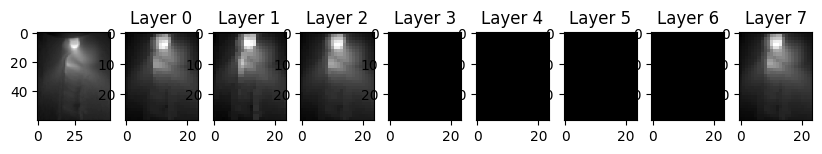

In [7]:
# Set up random paramaters, which will then be the trainable weights of the quanvolutional kernel
dev = qml.device(DEVICE, wires=max(MAX_CHANNELS, MAX_KERNELSIZE*MAX_KERNELSIZE))

# Implementation of two different families of random quanvolutional networks
@qml.qnode(dev)
def xrand1(n_channels, kernel_size, input, weights=np.random.uniform(high=2 * np.pi, size=(4, 2*2))):
    # Encoding of classical input values from kernel
    for wire in range(kernel_size*kernel_size):
        qml.RX(np.pi * input[wire], wires=wire)

    # Random quantum circuit
    RandomLayers(weights, wires=list(range(n_channels)))

    # Measurement producing classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_channels)]

@qml.qnode(dev)
def xrand2(n_channels, kernel_size, input, weights=np.random.uniform(high=2 * np.pi, size=(4, 2*2))):
    # Encoding of classical input values from kernel
    for wire in range(kernel_size*kernel_size):
        qml.RX(np.pi * input[wire], wires=wire)

    # Random quantum circuit
    RandomLayers(weights, wires=list(range(n_channels)))

    # Measurement producing classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_channels)]

# Test on a multi-layered convolution. Note the keras layers returns a tuple wrapping the array.
c_test_images = keras.layers.Conv2D(8, 2, activation="relu", strides=1)(test_images[0:10]),
c_test_images = keras.layers.MaxPooling2D(pool_size=3, strides=2)(tuple(c_test_images)[0]),
c_test_images = tuple(c_test_images)[0]

fig, axes = plt.subplots(1, 9, figsize=(10, 10))
axes[0].imshow(test_images[0,:,:,0], cmap="gray") # Lighter indicate higher value
for l in range(0,8):
    axes[l + 1].set_title("Layer {1:d}".format(1, l))
    axes[l + 1].imshow(c_test_images[0,:,:,l], cmap="gray") # Lighter indicate higher value
print("Size of convolved partial test set:\t", c_test_images.shape)


/home/samaria/.local/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[0.03478113 0.04256277 0.03511367 0.04375701]
[array(0.50126958), array(0.36563914)]
[1.79676639e+00 3.58777545e-01 5.19342188e-01 1.93130250e+00
 1.70920279e+00 1.36478278e+00 1.26599990e+00 1.96306611e+00
 9.59482260e-02 1.31875082e+00 1.41532749e+00 4.30471520e-01
 1.10024002e+00 1.23708101e+00 1.92164952e-03 6.76872971e-02]


Matplotlib is building the font cache; this may take a moment.
/tmp/ipykernel_10619/3029275216.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # Use qml.draw_mpl to draw out the circuit


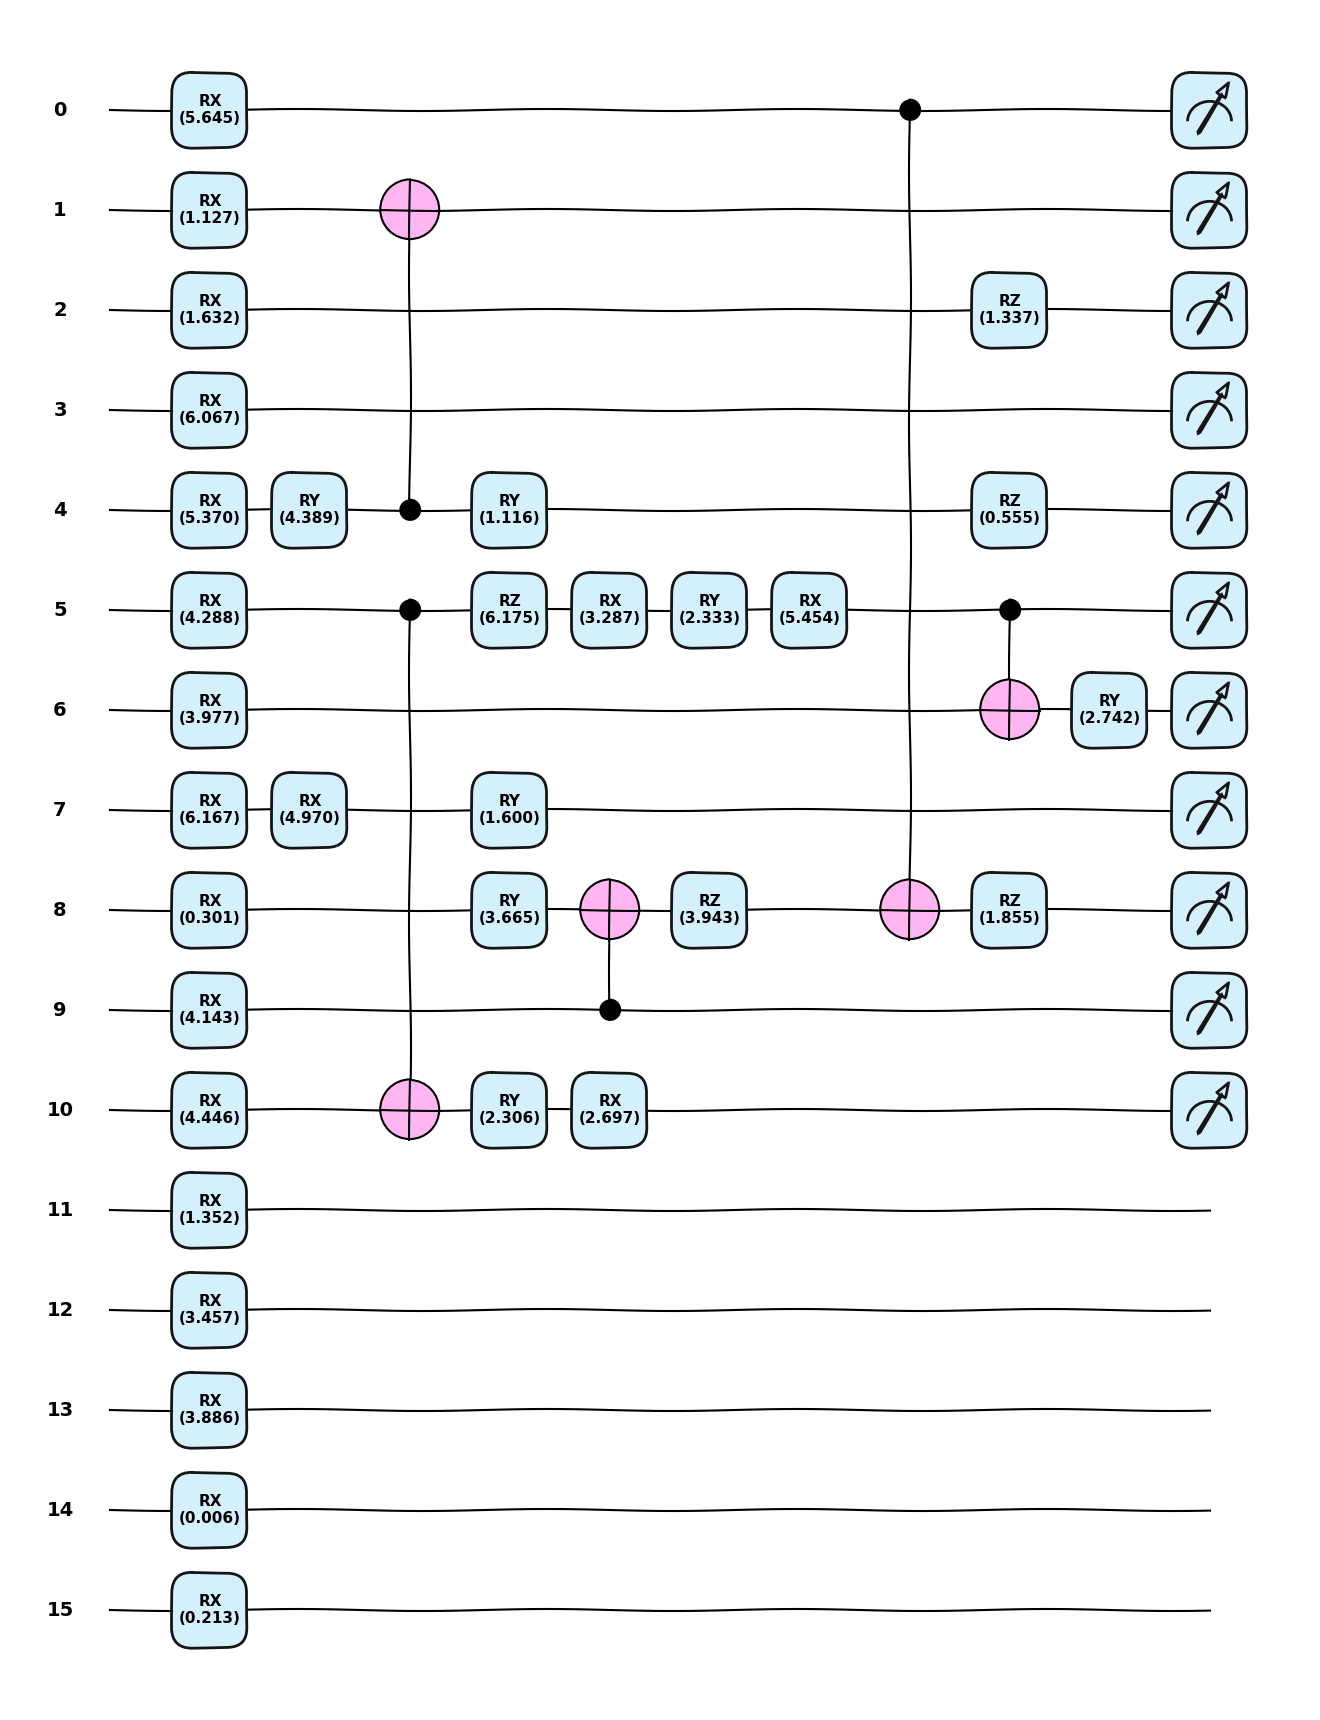

In [8]:
# Visualize a demo circuit we will use, using a sample convolution
demofilter = generatefilter(c_test_images[0], 0, 0, 1, 2)
democircuit = xrand1(2, 2, demofilter)
print(np.array(demofilter))
print(democircuit) # Print out the circuit

# Draw a circuit of the xrand family, using a random parametrization
n_channels, kernel_size = 11, 4
demofilter = np.random.uniform(high=2, size=(n_channels, kernel_size*kernel_size))[0]
print(np.array(demofilter))
drawer = qml.draw_mpl(xrand1, style='pennylane_sketch', decimals=3)
fig, ax = drawer(n_channels, kernel_size, demofilter)
fig.show() # Use qml.draw_mpl to draw out the circuit

##### Models and Hyperparameters

The model is prescribed by the original paper, but with some of the layers removed for space and time requirements. Even with this partial model the performance is noticeably better than the random classifier.

In [9]:
seq = keras.models.Sequential([
    keras.layers.Resizing(HEIGHT//2, WIDTH//2),
    keras.layers.Conv2D(4, 2, activation="relu", strides=1),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Conv2D(4, 2, activation="relu", strides=1),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    #keras.layers.Conv2D(64, 5, activation="relu", strides=1),
    #keras.layers.MaxPooling2D(pool_size=5, strides=2),
    #keras.layers.Conv2D(128, 5, activation="relu", strides=1),
    #keras.layers.MaxPooling2D(pool_size=5, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(24, activation="relu"),
    keras.layers.Dense(LABELS, activation="softmax")
])

qseq = keras.models.Sequential([
    Quanv2D(xrand1, 4, 2, activation=None),
    Quanv2D(xrand2, 4, 2, activation=None),
    # Quanv2D(xrand3, 64, 5, activation=None),
    # Quanv2D(xrand4, 128, 5, activation=None),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(24, activation="relu"),
    keras.layers.Dense(LABELS, activation="softmax")
])

def compile_model(model):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""

    model.compile(
        run_eagerly = True, # Allows embedding quanvolutional circuit as a Keras layer
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training the dataset classically

This section will be computationally expensive. The results will also be stored in the form of a history.

In [10]:
c_history = compile_model(seq).fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

print(seq.summary())

Epoch 1/128


W0000 00:00:1725080234.282496   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.284783   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.287032   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.289348   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.293434   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.297374   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.303664   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.308712   10619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725080234.315097   10619 gp

128/128 - 11s - 84ms/step - accuracy: 0.4814 - loss: 1.3745 - val_accuracy: 0.3906 - val_loss: 1.7315
Epoch 2/128
128/128 - 4s - 32ms/step - accuracy: 0.7793 - loss: 0.6562 - val_accuracy: 0.3750 - val_loss: 1.6947
Epoch 3/128
128/128 - 4s - 30ms/step - accuracy: 0.8428 - loss: 0.4232 - val_accuracy: 0.3906 - val_loss: 1.8086
Epoch 4/128
128/128 - 4s - 31ms/step - accuracy: 0.8721 - loss: 0.3483 - val_accuracy: 0.1797 - val_loss: 2.3474
Epoch 5/128
128/128 - 4s - 31ms/step - accuracy: 0.8906 - loss: 0.2790 - val_accuracy: 0.2734 - val_loss: 2.3956
Epoch 6/128
128/128 - 4s - 31ms/step - accuracy: 0.9160 - loss: 0.2245 - val_accuracy: 0.2266 - val_loss: 2.9026
Epoch 7/128
128/128 - 4s - 31ms/step - accuracy: 0.9287 - loss: 0.1950 - val_accuracy: 0.2812 - val_loss: 2.9424
Epoch 8/128
128/128 - 4s - 32ms/step - accuracy: 0.9209 - loss: 0.2044 - val_accuracy: 0.2578 - val_loss: 2.7545
Epoch 9/128
128/128 - 4s - 33ms/step - accuracy: 0.9570 - loss: 0.1368 - val_accuracy: 0.2109 - val_loss: 2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (8, 400, 487, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 399, 486, 4)       │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 199, 243, 4)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 198, 242, 4)       │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 99, 121, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 47916)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 64)                │     3,066,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 24)                │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (8, 6)                 │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,205,460 (35.12 MB)

 Trainable params: 3,068,486 (11.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,136,974 (23.41 MB)

None


### Quanvoluting the image

This is the inttroduction of the peak of this project! First, we show sample images undergoing two layers of quanvolution:

In [11]:
q1_test_images = Quanv2D(xrand1, 4, 2, activation=None)(test_images[0:1,])
q2_test_images = Quanv2D(xrand2, 4, 2, activation=None)(q1_test_images[0:1,])
print("Tensor shapes\nBase:\t{}".format(test_images[0:1].shape))
print("Quanv1:\t".format(test_images[1:1].shape))
print("Quanv2:\t".format(test_images[2:1].shape))

Images quanvolved: 	1/1
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	1/1
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_3/quanvkernel>
Tensor shapes
Base:	(1, 60, 50, 1)
Quanv1:	
Quanv2:	


[[-0.94833809 -0.93148381 -0.9682227  -0.94833809 -0.8817057  -0.81584473
  -0.78001759 -0.80444241 -0.8817057  -0.81584473 -0.83708902 -0.8817057 ]
 [-0.93148381 -0.89644351 -0.84695639 -0.78001759 -0.67644597  0.27624919
   0.89802157  0.11741706 -0.54296309 -0.67644597 -0.79250393 -0.82672276]
 [-0.89644351 -0.87369887 -0.80444241 -0.69303318 -0.03899015  0.97985139
  -0.85633808  0.49258314 -0.15930035 -0.3793145  -0.62298126 -0.75335885]
 [-0.90320309 -0.82672276 -0.72438665 -0.60391438 -0.15930035  0.96269095
  -0.37931467  0.98649022  0.49258314  0.08578491 -0.3793145  -0.69303318]
 [-0.8817057  -0.80444241 -0.69303318 -0.56390441  0.11741706  0.89802157
   0.78317975  0.76055879  0.94046758  0.46261138 -0.24544264 -0.60391438]
 [-0.84695639 -0.78001759 -0.62298126 -0.47643049  0.30785436  0.7370471
   0.99983267  0.99849452  0.95220236  0.46261138 -0.24544264 -0.56390441]
 [-0.82672276 -0.72438665 -0.54296309 -0.15930035  0.08578491  0.99582083
   0.88154846  0.99582086  0.7605

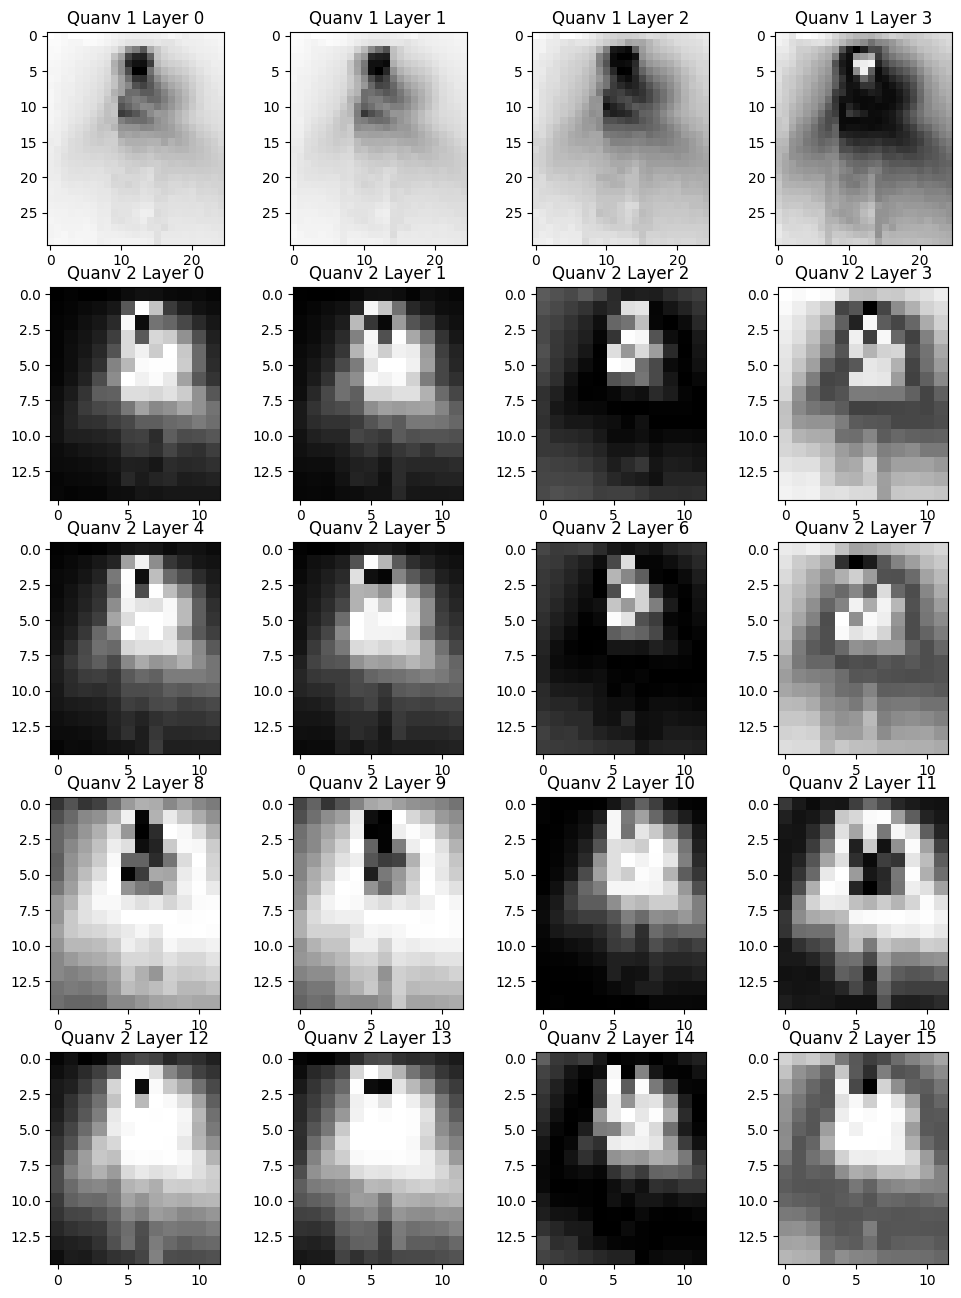

In [12]:
fig, axes = plt.subplots(5, 4, figsize=(12, 16))
for l in range(0,4):
    axes[0, l].set_title("Quanv {0:d} Layer {1:d}".format(1, l))
    axes[0, l].imshow(q1_test_images[0,:,:,l], cmap="gray") # Lighter indicate higher value
for l in range(0,16):
    axes[l // 4 + 1, l % 4].set_title("Quanv {0:d} Layer {1:d}".format(2, l))
    axes[l // 4 + 1, l % 4].imshow(q2_test_images[0,:,:,l], cmap="gray") # Lighter indicate higher value

print(q2_test_images[0,:,:,4])

### Training the dataset quantumly

Takes a long time! We will train the model quantumly!

In [ ]:
q_history = compile_model(qseq).fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=24,
    verbose=2,
)

print(qseq.summary())

Epoch 1/24
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_1/quanvkernel>


/home/samaria/.local/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['quanvkernel', 'bias', 'quanvkernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_1/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_1/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_1/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_1/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_1/quanvkernel>
Images quanvolved: 	8/8
<KerasVariable shape=(2, 2

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))

ax1.plot(c_history.history["accuracy"], "-k", label="With conventional layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(c_history.history["loss"], "-k", label="With conventional layer")
ax2.set_yscale("log")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()

ax3.plot(c_history.history["val_accuracy"], "-k", label="With conventional layer")
ax3.set_ylabel("Accuracy")
ax3.set_ylim([0, 1])
ax3.set_xlabel("Epoch")
ax3.legend()

ax4.plot(c_history.history["val_loss"], "-k", label="With conventional layer")
ax4.set_yscale("log")
ax4.set_ylabel("Loss")
ax4.set_xlabel("Epoch")
ax4.legend()

plt.tight_layout()
plt.show()

In [ ]:
ax1.plot(q_history.history["accuracy"], "-b", label="With quantum layer")
ax2.plot(q_history.history["loss"], "-b", label="With quantum layer")
ax3.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax4.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
plt.show()

## Discussion

The weld classification problem comes in two varieties: (1) A six-classification problem which separates the welds into good cases and five different types of defective cases, and where welds considered to be defective belong to one and only one defect category; (2) A two-classification problem which separates the welds into good and defective cases. According to the paper, the two-classification problem performed considerably better than the six-classification problem, but only if the number of convolutional and dense layers is high.

The demo contains a (rather rough) Keras implementation of the quanvolutional layer, with the bias function disabled. Nvidia cuQuantum and Pennylane Lightning is used to simulate qubits on the GPU, but even then space is precious because a single consumer-grade GPU (such as a mobile RTX3050) can only handle significantly downscaled images, shallower layers, and low batch sizes. Excluded layers are expliticly commented out. The quanvolutional method is very computationally expensive and we are not able to find the final results within the time frame. However, there are cells which demonstrate applying quanvolutional layers to sample images.

In the next steps, we could consider replacing random quanvolutional circuits with certain structured circuits.
